# Analysis of crime pattern in San Francisco and Seattle using Data Visualization

## Summary
In this report we analyze the crime pattern in the cities of San Francisco and Seattle using Data Visualization techniques as part of assigment in communicating data science results course from Data Science at Scale specialization. The analysis was based on six questions related to crime pattern in San Francisco and Seattle. R and Ipython notebook were used to perform the graphs. Finally, the conclusion of this report indicates that the crime pattern of these cities is different.

In [2]:
suppressMessages(library(xml2))
library(ggplot2)
library(ggmap)
suppressMessages(library(dplyr))
library(scales)
suppressMessages(library(lubridate))
library(stringr)
library(rvest)
library(stringr)
library(tidyr)

In [3]:
Sys.setenv(LANG = "en")

locale.crime <- capture.output(Sys.setlocale("LC_TIME", "C"))

remove.parenthesis <- function(x)
{
  return(gsub("\\(|\\)","",x))
}


In [4]:
sanfrancisco <- read.csv(file="sanfrancisco_incidents_summer_2014.csv")


seattle <- read.csv(file="seattle_incidents_summer_2014.csv")


In [5]:
#### 
#### We transform the san francisco data 
###



### We combine THEFT, ROBBERY and BURGLARY. 

sanfrancisco$Category <- as.character(sanfrancisco$Category)

sanfrancisco$Category <- gsub(".*THEFT.*", "THEFT/ROBBERY", sanfrancisco$Category)
sanfrancisco$Category <- gsub(".*ROBBERY.*", "THEFT/ROBBERY", sanfrancisco$Category)
sanfrancisco$Category <- gsub(".*BURGLARY.*", "THEFT/ROBBERY", sanfrancisco$Category)


### sort(round(prop.table(table(sanfrancisco$Category)),2), decreasing = TRUE) 

### We combine the categories of crime with a relative frequency
### less than 0.10 into OTHER

rel.freq <- sort(round(prop.table(table(sanfrancisco$Category)),2), decreasing = TRUE) 

indexs <- rel.freq < 0.10

names.crimes <- names(rel.freq[indexs])

for ( i in 1:length(names.crimes))
{
  sanfrancisco$Category <- gsub(names.crimes[i], "OTHERS", sanfrancisco$Category)  
}

sanfrancisco$Category <- as.factor(sanfrancisco$Category)


In [6]:
#### 
#### We transform the seattle data 
###



### We combine THEFT, ROBBERY and BURGLARY. 


seattle$Offense.Type <- as.character(seattle$Offense.Type)

seattle$Offense.Type <- gsub(".*THEFT.*", "THEFT/ROBBERY", seattle$Offense.Type)
seattle$Offense.Type <- gsub(".*ROBBERY.*", "THEFT/ROBBERY", seattle$Offense.Type)
seattle$Offense.Type <- gsub(".*BURGLARY.*", "THEFT/ROBBERY", seattle$Offense.Type)

## We replace parenthesis 

for (i in 1:length(seattle$Offense.Type))
{
  seattle$Offense.Type[i] <- remove.parenthesis(seattle$Offense.Type[i])  
}


### sort(round(prop.table(table(seattle$Offense.Type)),2), decreasing = TRUE) 

### We combine the categories of crime with a relative frequency
### less than 0.04 into OTHERS

rel.freq <- sort(round(prop.table(table(seattle$Offense.Type)),2), decreasing = TRUE) 

indexs <- rel.freq < 0.04

names.crimes <- names(rel.freq[indexs])

names.crimes <- paste("^", names.crimes, "$", collapse = "|", sep="")

seattle$Offense.Type <- gsub(names.crimes, "OTHERS", seattle$Offense.Type)  

seattle$Offense.Type <- as.factor(seattle$Offense.Type)


## For either city, how do incidents vary by time of day? Which incidents are most common in the evening? During what periods of the day are robberies most common?

The below graph shows the type of crime through the days of the week for San Francisco. It seems that the incididents are most common in the evening beginning. Robberies and theft are most common around 16-20 hour.

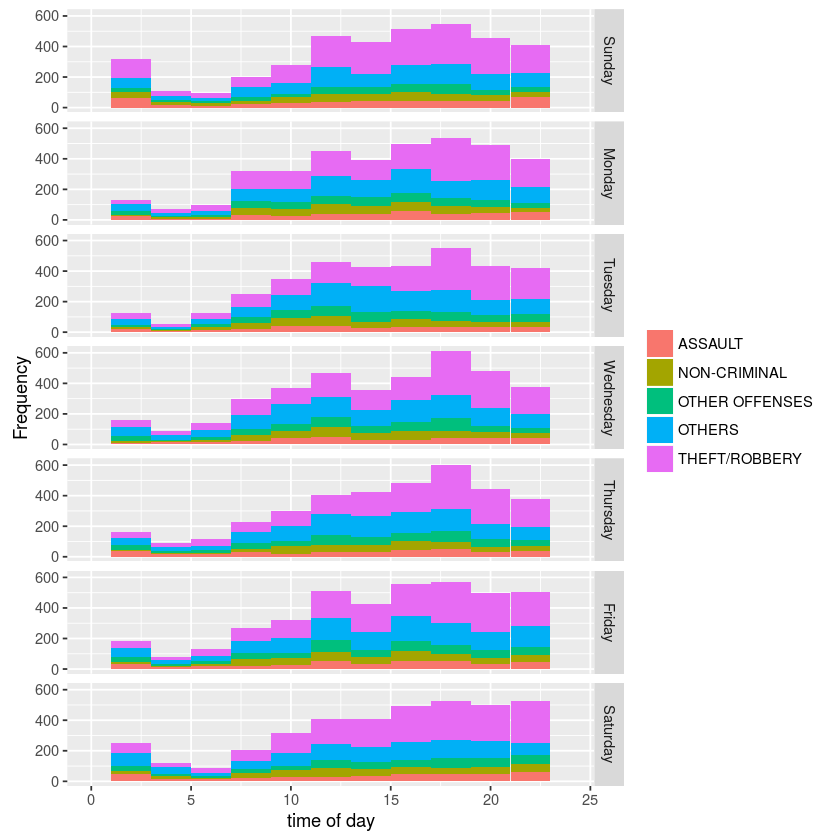

In [7]:
### graph 1

week  <- c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday")

sanfrancisco$DayOfWeek <- factor(as.character(sanfrancisco$DayOfWeek), levels = week, ordered=TRUE)


sanfrancisco$start.ct   <- as.POSIXct(paste(sanfrancisco$Date, sanfrancisco$Time, sep = " "), format  = "%m/%d/%Y %H:%M") 

sanfrancisco$start.hour <- as.POSIXlt(sanfrancisco$start.ct)$hour + as.POSIXlt(sanfrancisco$start.ct)$min/60 + as.POSIXlt(sanfrancisco$start.ct)$sec/3600

g <- ggplot(sanfrancisco, aes(x=start.hour, fill = factor(Category)))
g <- g + geom_histogram(binwidth = 2)
g <- g + facet_grid(DayOfWeek~.) +  xlim(0,24) + xlab("time of day") + ylab("Frequency")

g <- g + guides(fill=guide_legend(title=NULL))

g <- g + theme(legend.title=element_blank())


g 


The following graph presents the type of crime through the days of the week for Seattle. It seems that the pattern is similar to San Francisco. Moreover, robberies and theft are most common around 14-19 hour so it pattern is different to San Francisco.

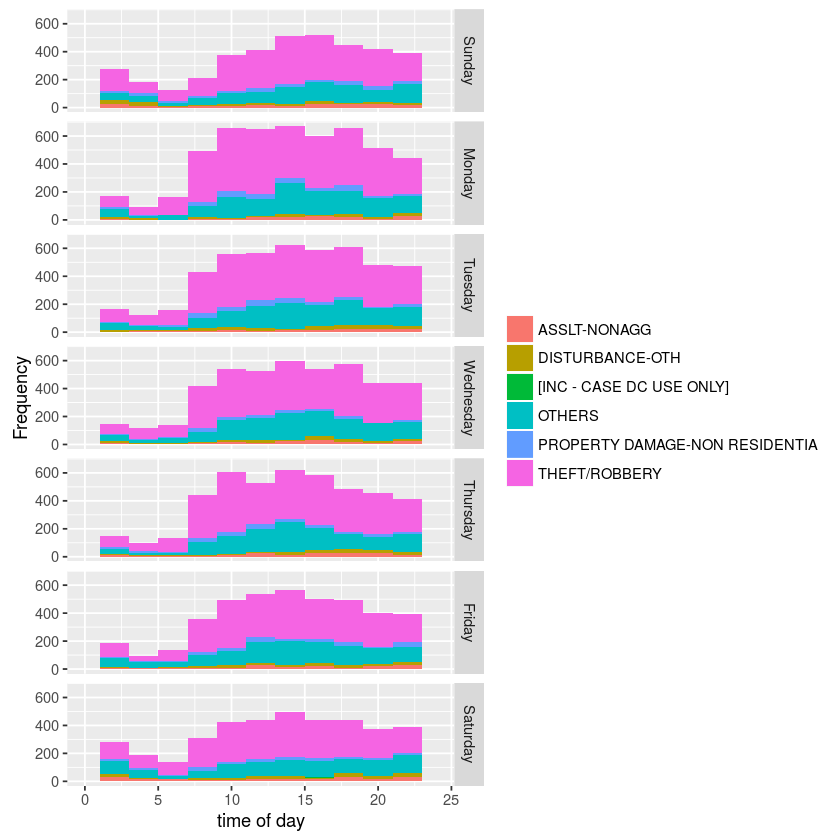

In [8]:
### graph 2


seattle$start.ct   <- as.POSIXct(as.character(seattle$Date.Reported), format  = "%m/%d/%Y %I:%M:%S %p") 

seattle$start.hour <- as.POSIXlt(seattle$start.ct)$hour + as.POSIXlt(seattle$start.ct)$min/60 + as.POSIXlt(seattle$start.ct)$sec/3600


seattle$day <- weekdays(strptime(seattle$start.ct, "%Y-%m-%d"))

week  <- c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday")

seattle$day <- factor(seattle$day, levels = week, ordered=TRUE)


g2 <- ggplot(seattle, aes(x=start.hour, fill = factor(Offense.Type)))
g2 <- g2 + geom_histogram(binwidth = 2)
g2 <- g2 + facet_grid(day~.) +  xlim(0,24) + xlab("time of day") + ylab("Frequency")

g2 <- g2 + guides(fill=guide_legend(title=NULL))

g2 <- g2 + theme(legend.title=element_blank())


g2


## For either city, how do incidents vary by neighborhood? Which incidents are most common in the city center? In what areas or neighborhoods are robberies or thefts most common?

The following map shows the spatial concentrations of robberies or thefts through San Francisco. We omit some data for the purpose of establishing the zones with more incidence. Moreover, the thefts and robberies are most frequent than other type of crime that is why we omit other type of crimes (the other crimes are not distinguished in the map). It seems that there are two zones: Union Square and South of Market. The first is a 2.6-acre (1.1 ha) public plaza and the second is a relatively large neighborhood, according to Wikipedia.   

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=san+francisco&zoom=14&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=san%20francisco&sensor=false
Warning message:
“Removed 4851 rows containing non-finite values (stat_density2d).”

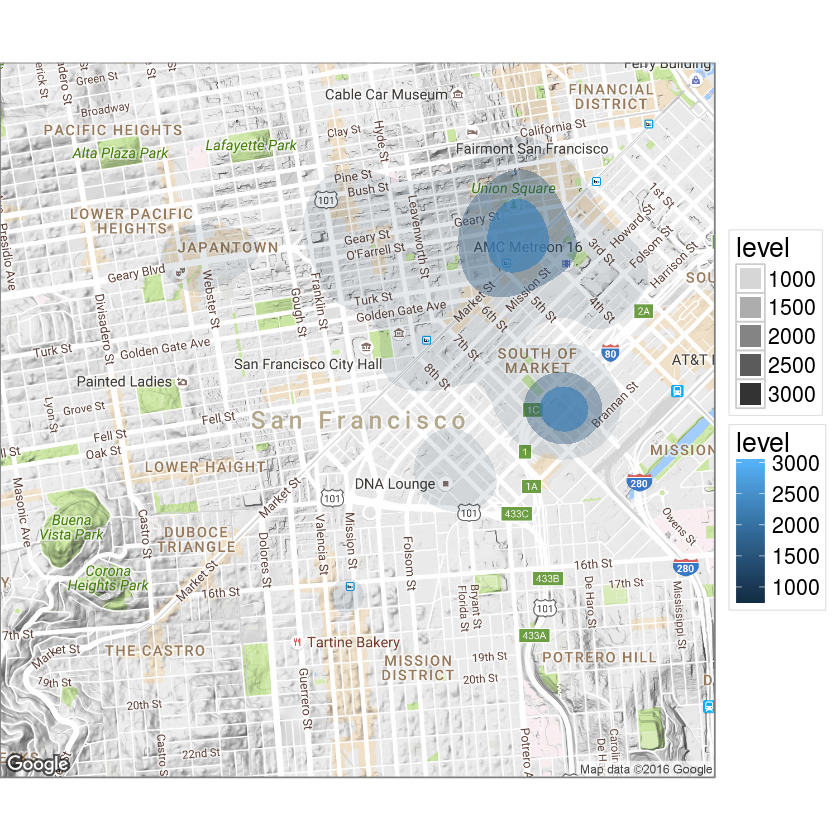

In [9]:
### graph 3


theme_set(theme_bw(16))

sanfrancisco2 <- sanfrancisco %>% 
  select(X, Y, Category) %>% 
  filter(Category == "THEFT/ROBBERY")


SanFrancisco <- get_map("san francisco", zoom = 14)

SanFranciscoMap <- ggmap(SanFrancisco, extent = "device", legend = "topleft")

g3 <- suppressMessages(SanFranciscoMap +
  stat_density2d(
    aes(x = X, y = Y, fill = ..level.., alpha = ..level..),
    size = 2, bins = 4, data = sanfrancisco2,
    geom = "polygon"
  ))

g3 <- g3 + theme(legend.position="right")

suppressMessages(g3)



The map below presents the spatial concentrations of robberies or thefts through Seattle. We omit some data for the reason of establishing the zones with more incidence. Moreover, the thefts and robberies are most frequent than other type of crime that is why we omit other type of crimes (the other crimes are not distinguished in the map). It seems that there are three zones: Seattle Art Museum, Paramount Theatre, and Pioneer Square. The first and second zone is rounded by several businesses such as: banks, coffes and restaurants (according to google maps). The Pioneer Square is a that neighborhood that lacks definitive borders.  

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=seattle&zoom=14&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=seattle&sensor=false
Warning message:
“Removed 14457 rows containing non-finite values (stat_density2d).”

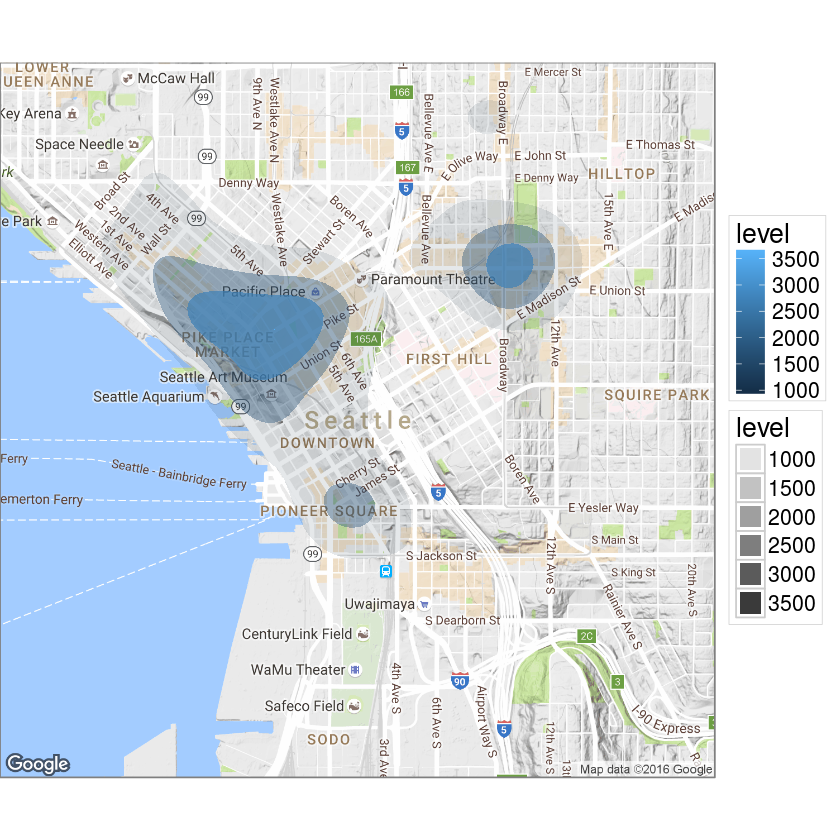

In [10]:
### graph 4


theme_set(theme_bw(16))

seattle2 <- seattle %>% 
  select(Longitude, Latitude, Offense.Type) %>% 
  filter(Offense.Type == "THEFT/ROBBERY")


Seattle <- get_map("seattle", zoom = 14)

SeattleMap <- ggmap(Seattle, extent = "device", legend = "topleft")

g4 <- SeattleMap +
  stat_density2d(
    aes(x = Longitude, y = Latitude, fill = ..level.., alpha = ..level..),
    size = 2, bins = 4, data = seattle2,
    geom = "polygon"
  )

g4 <- g4 + theme(legend.position="right")

g4 


## For either city, how do incidents vary month to month in the Summer 2014 dataset?

In the graph below is shown the incidents through of months for San Francisco in the Summer 2014. Around mid-July the incidents related to theft or robbery presents a maximum. The pattern of crimes through of months (theft-robbery) in San Francisco tends to fluctuate around 125 with high random variations.

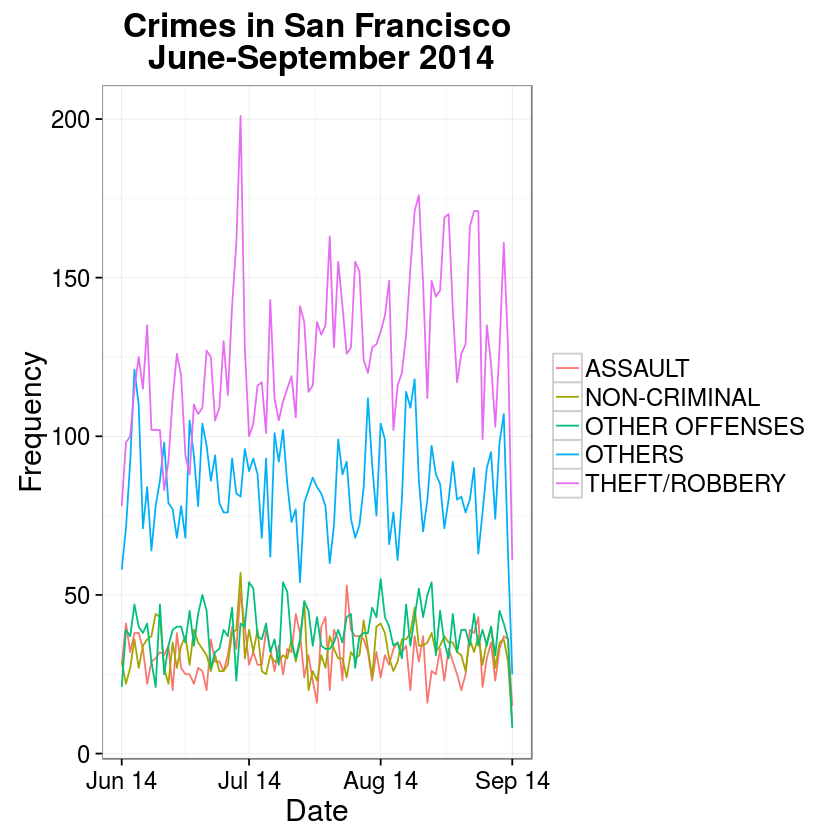

In [11]:
sanfrancisco$Date2 <- as.Date(sanfrancisco$start.ct)

total.sanfrancisco <- sanfrancisco %>% 
                      select(Category,Date2) %>%
                      group_by(Category, Date2) %>%
                      summarise(count = n())


g5 <- ggplot(total.sanfrancisco, aes(Date2, count, colour=Category)) 
g5 <- g5 + geom_line(na.rm=TRUE) 
g5 <- g5 + ggtitle("Crimes in San Francisco\n June-September 2014")
g5 <- g5 + xlab("Date") + ylab("Frequency") 
g5 <- g5 + scale_x_date(labels=date_format ("%b %y"))
g5 <- g5 +  theme(plot.title = element_text(lineheight=.8, face="bold", 
                                size = 20)) 
g5 <- g5 +  theme(text = element_text(size=18))

g5 <- g5 + guides(fill=guide_legend(title=NULL))

g5 <- g5 + theme(legend.title=element_blank())

g5

The following graph shows the incidents through of months for Seattle from July 2014 to July 2015. The pattern of crimes through months (theft-robbery) is very different to San Francisco, since that tends to fluctuate around 200 with high random variations until mid-October of 2014 where there is a significant drop for all incidents.

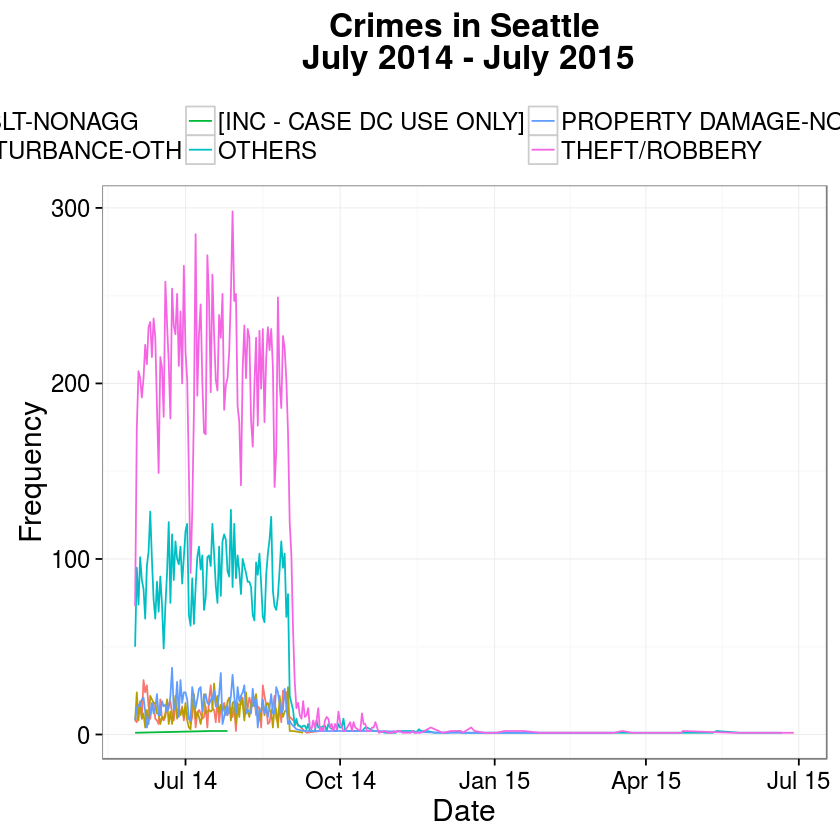

In [12]:
seattle$Date2 <- as.Date(seattle$start.ct)

total.seattle <- seattle %>% 
  select(Offense.Type,Date2) %>%
  group_by(Offense.Type, Date2) %>%
  summarise(count = n())


g6 <- ggplot(total.seattle, aes(Date2, count, colour=Offense.Type)) 
g6 <- g6 + geom_line(na.rm=TRUE) 
g6 <- g6 + ggtitle("Crimes in Seattle\n July 2014 - July 2015")
g6 <- g6 + xlab("Date") + ylab("Frequency") 
g6 <- g6 + scale_x_date(labels=date_format ("%b %y"))
g6 <- g6 +  theme(plot.title = element_text(lineheight=.8, face="bold", 
                                            size = 20)) 
g6 <- g6 +  theme(text = element_text(size=18))


g6 <- g6 + guides(fill=guide_legend(title=NULL))

g6 <- g6 + theme(legend.title=element_blank())

g6 <- g6 + theme(legend.position="top")

g6

## What can we infer broadly about the differences in crime patterns between Seattle and San Francisco? Does one city tend to have more crime than the other, per capita? Do the relative frequencies of types of incidents change materially between the two cities? (NOTE: The two datasets do not have the same schema, so comparisons will require some work and some assumptions. This will require extra work, but you will be working at the forefront of what is known!)

According to us national census:
* Seattle has 652,405 inhabitants
* San Francisco has 837,442 inhabitants

According to Wikipedia: 
* San Francisco has 49 square miles
* Seattle has 142.5 square miles

In spite of the differences between San Francisco and Seattle, the city of Seattle has experienced a decline of crimes, starting from mid-October of 2014.

## For either city, do certain crimes correlate with environmental factors such as temperature? (To answer this kind of question, you will need to identify and use external data sources!)

To answer this question was necessary to use techniques of [web scraping](https://en.wikipedia.org/wiki/Web_scraping "Web Scraping") 
to obtain information of temperature of the web site: 

[https://www.wunderground.com/ ](https://www.wunderground.com/ "") 

The following graphs show frequencies of theft or robbery incidents and temperatures for San Francisco. To visualize better the temperature the following operations were performed: 

* We add 100 to the temperature of San Francisco
* We add 200 to the temperature of Seattle 

In the case of San Francisco, it seems that increase of temperature are correlated with increases of frequencies of theft or robbery incidents, but this association is weak. Finally, for Seattle city the association between frequencies of theft or robbery incidents and temperature is not clear.


Joining, by = "Date"


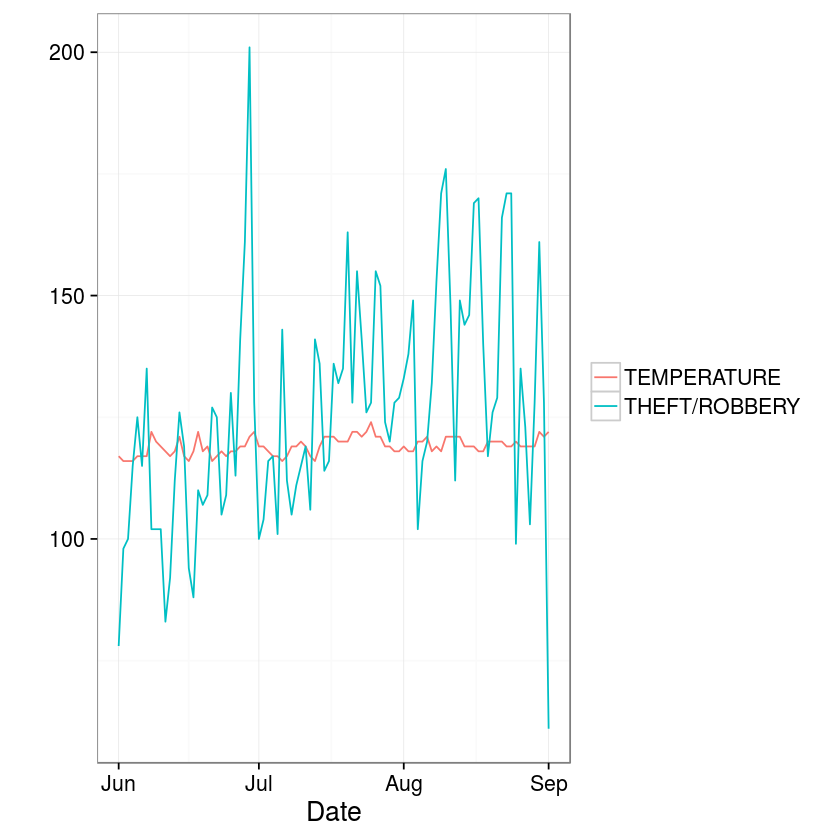

In [13]:
san.francisco.date.temp <- read.csv(file="sanfrancisco_date_temp.csv")


san.francisco.date.temp$Date <- as.POSIXct(as.character(san.francisco.date.temp$Date), format  = "%Y-%m-%d")


total.sanfrancisco.theft.rob <- sanfrancisco %>% 
  select(Category,Date2) %>%
  filter(Category=="THEFT/ROBBERY") %>%
  group_by(Category, Date2) %>%
  summarise(count = n())

colnames(total.sanfrancisco.theft.rob)[2] <- "Date"


total.sanfrancisco.theft.rob$Date <- as.character(total.sanfrancisco.theft.rob$Date)

san.francisco.date.temp$Date <- as.character(san.francisco.date.temp$Date)


data.temp.count.sanfrancisco <-  total.sanfrancisco.theft.rob %>% inner_join(san.francisco.date.temp)

data.temp.count.sanfrancisco.count <- data.temp.count.sanfrancisco %>% select(Category, Date, count)

colnames(data.temp.count.sanfrancisco.count)[3] <- "X"

data.temp.count.sanfrancisco.count$type.incident <- "THEFT/ROBBERY"


data.temp.count.sanfrancisco.temp <- data.temp.count.sanfrancisco %>% select(Category, Date, Temp)

colnames(data.temp.count.sanfrancisco.temp)[3] <- "X"

data.temp.count.sanfrancisco.temp$X <- data.temp.count.sanfrancisco.temp$X + 100

data.temp.count.sanfrancisco.temp$type.incident <- "TEMPERATURE"

data.temp.count.sanfrancisco <- rbind(data.temp.count.sanfrancisco.count, data.temp.count.sanfrancisco.temp)


data.temp.count.sanfrancisco$Date <- as.POSIXct(as.character(data.temp.count.sanfrancisco$Date), format  = "%Y-%m-%d")

g7 <- ggplot(data = data.temp.count.sanfrancisco, 
             aes(x=Date, y=X, colour=type.incident ))

g7 <- g7 + geom_line()

g7 <- g7 + ylab("") 
  
g7 <- g7 + guides(fill=guide_legend(title=NULL))

g7 <- g7 + theme(legend.title=element_blank())

g7


Joining, by = "Date"


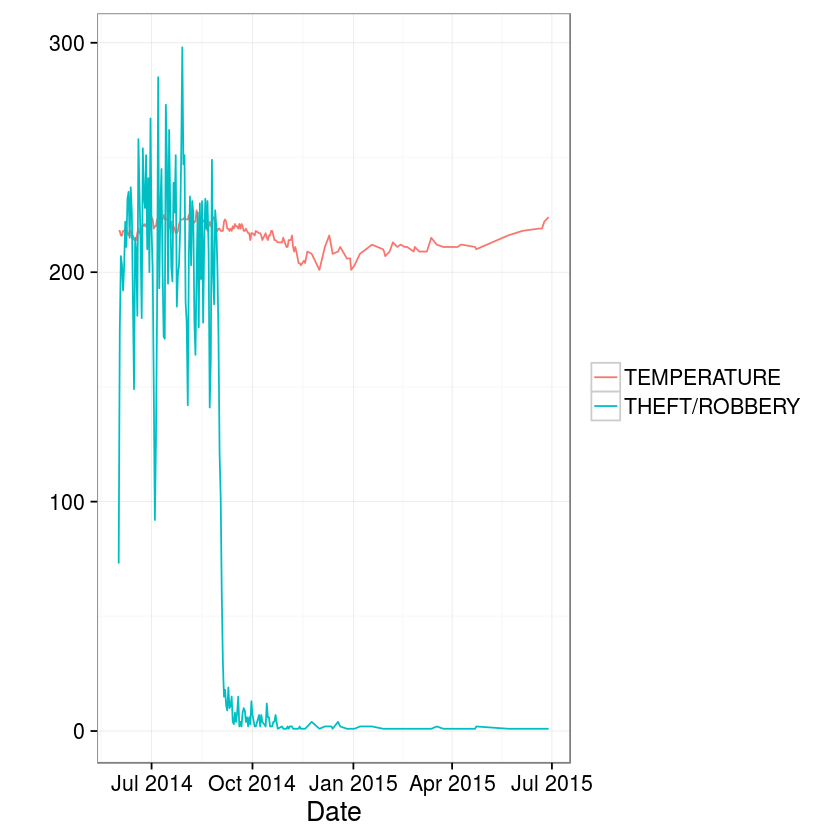

In [14]:
seattle.date.temp <- read.csv(file="seattle_date_temp.csv")


seattle.date.temp$Date <- as.POSIXct(as.character(seattle.date.temp$Date), format  = "%Y-%m-%d")


total.seattle.theft.rob <- seattle %>% 
  select(Offense.Type,Date2) %>%
  filter(Offense.Type=="THEFT/ROBBERY") %>%
  group_by(Offense.Type, Date2) %>%
  summarise(count = n())

colnames(total.seattle.theft.rob)[2] <- "Date"


total.seattle.theft.rob$Date <- as.character(total.seattle.theft.rob$Date)

seattle.date.temp$Date <- as.character(seattle.date.temp$Date)


data.temp.count.seattle <-  total.seattle.theft.rob %>% inner_join(seattle.date.temp)

data.temp.count.seattle.count <- data.temp.count.seattle %>% select(Offense.Type, Date, count)

colnames(data.temp.count.seattle.count)[3] <- "X"

data.temp.count.seattle.count$type.incident <- "THEFT/ROBBERY"


data.temp.count.seattle.temp <- data.temp.count.seattle %>% select(Offense.Type, Date, Temp)

colnames(data.temp.count.seattle.temp)[3] <- "X"

data.temp.count.seattle.temp$X <- data.temp.count.seattle.temp$X + 200


data.temp.count.seattle.temp$type.incident <- "TEMPERATURE"

data.temp.count.seattle <- rbind(data.temp.count.seattle.count, data.temp.count.seattle.temp)


data.temp.count.seattle$Date <- as.POSIXct(as.character(data.temp.count.seattle$Date), format  = "%Y-%m-%d")

g8 <- ggplot(data = data.temp.count.seattle, 
             aes(x=Date, y=X, colour=type.incident ))

g8 <- g8 + geom_line()

g8 <- g8 + ylab("") 

g8 <- g8 + guides(fill=guide_legend(title=NULL))

g8 <- g8 + theme(legend.title=element_blank())

g8

## Conclusions

There are four conclusions that can be derived:
* The rate of incidents for Seattle city changed, the reason for that may be the implementation of better policies against the crime.
* For the two cities: public squares and neighborhood are zones with high concentrations of incidents related to theft or robbery. 
* It is high probable that the possible association between frequencies of theft or robbery incidents and temperature is spurious, it can be interesting to use some analytical method to prove this or document review. 
* The statistical software R in conjunction with Ipython Notebook represents a powerful way to generate a reproducible report with high quality maps.